In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm

url='https://drive.google.com/file/d/1wcwKvqrEsACmBQMeJYEVdlxldOaodSCh/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url, sep = ';')

## The purpose of the notebook

This notebook is created for an experimental application of **Principal component analysis (PCA)** for regression task with a vast number of categorical features. The goal of the regression is to predict a number of death rate per 100k population based on:
- Region name
- Country name
- Year
- Sex
- Age group
- Percentage of suicides out of deaths

Thus, we will consider only year and percentage of suicides as numerical features. One can argue that age group can be treated the same way but emperically regression shows best result when age is processed with one-hot encoding.

The description of the dataset you can find in the main part of the work or in pdf paper.

In [3]:
df = df[['Region Name','Country Name', 'Year','Sex','Age Group','Percentage of cause-specific deaths out of total deaths', 'Death rate per 100 000 population']]
df.head()

,Region Name,Country Name,Year,Sex,Age Group,Percentage of cause-specific deaths out of total deaths,Death rate per 100 000 population
0,Europe,Albania,1987,All,[Unknown],NaN,NaN
1,Europe,Albania,1987,All,[85+],0.044924,10.000000
2,Europe,Albania,1987,All,[80-84],0.000000,0.000000
3,Europe,Albania,1987,All,[75-79],0.047281,3.246753
4,Europe,Albania,1987,All,[70-74],0.000000,0.000000


In [4]:
df.dropna(inplace = True)

In [5]:
df = df.loc[df['Age Group'] != 'Unknown'].\
    loc[df['Age Group'] != '[All]']. \
    loc[df['Sex'] != 'All']

In [6]:
cat_features = pd.get_dummies(df[['Region Name', 'Country Name', 'Sex', 'Age Group']])
num_features = df[['Year', 'Percentage of cause-specific deaths out of total deaths']]

features = pd.merge(cat_features, num_features, left_index = True, right_index = True, how = 'inner')
features = features - features.mean(axis = 0)


target = df['Death rate per 100 000 population'] - df['Death rate per 100 000 population'].mean()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.5)

## The main part

When preprocessing including centering data is done, we can transform our feature space with PCA. In order to compare results of a regression we want to have scores (median absolute error) for each number of principal vectors from 1 to 130 in the list `median_absolute_errors`.

Visualization shows that **the minimal error is occured with 3 principal vectors** wich is suprisingly small number for 145-dimensional space. It shows a high level of correlation between features and a reduction of these relations helps avoid overfitting.   

In [8]:
n_components = np.arange(1,130)
median_absolute_errors = []

for n in tqdm(n_components):
    pca = PCA(n_components = n)
    pca.fit(x_train)
    x_train_transformed, x_test_transformed = pca.transform(x_train), pca.transform(x_test)

    lr = linear_model.LinearRegression()
    lr.fit(x_train_transformed, y_train)
    predictions = lr.predict(x_test_transformed)

    median_absolute_errors.append(median_absolute_error(predictions, y_test))

100%|██████████| 129/129 [05:40<00:00,  2.64s/it]


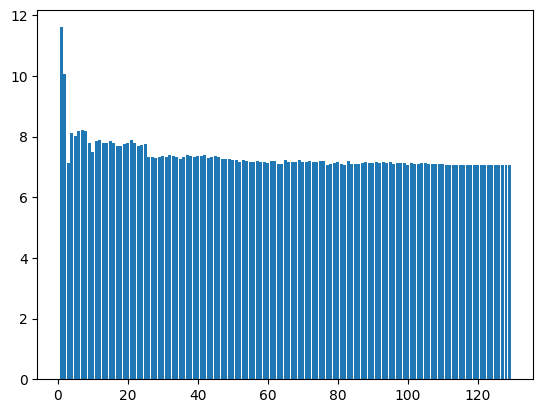

In [9]:
plt.bar(n_components, median_absolute_errors)
plt.show()

Moreover, PCA with 3 principal components gives slightly better results in predicting. Mean absolute percentage errors are:
- Linear regression without regularization - 2.959 %
- Ridge regularization - 2.957 %
- PCA + Ridge - 2.452 %
- PCA + only linear regression - 2.447 %

It's worth mentioning that this simple model performs well on the data and deviation from real values is not sizable.  

In [19]:
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)
predictions = lr.predict(x_test)

lr2 = linear_model.Ridge()
lr2.fit(x_train, y_train)
predictions2 = lr2.predict(x_test)

print(mean_absolute_percentage_error(y_test, predictions)) # printing results for average linear regression and Ridge regression
print(mean_absolute_percentage_error(y_test, predictions2))

2.9586538364338733
2.9572545531234296


In [18]:
pca = PCA(n_components = 3)
pca.fit(x_train)
x_train_transformed, x_test_transformed = pca.transform(x_train), pca.transform(x_test)

lr3 = linear_model.Ridge()
lr3.fit(x_train_transformed, y_train)
predictions3 = lr3.predict(x_test_transformed)

lr4 = linear_model.LinearRegression()
lr4.fit(x_train_transformed, y_train)
predictions4 = lr4.predict(x_test_transformed)

print(mean_absolute_percentage_error(predictions3, y_test))
print(mean_absolute_percentage_error(predictions4, y_test))

2.451606000157237
2.44681377987924
